## Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_emimTF2N_PR import configuration

## Create Model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## Calculate flash data

In [6]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.001,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    

Running pressure: 200000 and HFC feed fraction 0.001
Running pressure: 200000 and HFC feed fraction 0.15
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.3
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.5
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.001
Running pressure: 300000 and HFC feed fraction 0.15
Running pressure: 300000 and HFC feed fraction 0.2
Running pressure: 300000 and HFC feed fraction 0.3
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.5
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.001
Running pressure:

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
          infeasible point. Problem may be infeasible.
Infeasible.
Running pressure: 1600000 and HFC feed fraction 0.3
Running pressure: 1600000 and HFC feed fraction 0.4
Running pressure: 1600000 and HFC feed fraction 0.5
Running pressure: 1600000 and HFC feed fraction 0.72
Running pressure: 1600000 and HFC feed fraction 0.91
Running pressure: 1600000 and HFC feed fraction 0.99


In [7]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[0.89836582 0.88685897 0.88300193 0.87529439 0.86759554 0.85990532
  0.84301694 0.82846413 0.82234543]
 [0.84850763 0.83290698 0.82767664 0.81722372 0.80678173 0.79635124
  0.77344671 0.75371404 0.74541904]
 [0.79914017 0.78052998 0.77428295 0.76178814 0.74929456 0.73680451
  0.70934748 0.68566516 0.67570282]
 [0.75012432 0.72957923 0.72266275 0.70880242 0.69491142 0.6809958
  0.65031742 0.62377038 0.61257995]
 [0.70128787 0.67988328 0.67263711 0.65806267 0.64339168 0.62863741
  0.59593405 0.56745994 0.55541017]
 [0.6524103  0.63123937 0.62399942 0.60934268 0.59447604 0.57942583
  0.5457654  0.51616221 0.50355528]
 [0.60319764 0.58339976 0.57650449 0.56238745 0.54788384 0.53304253
  0.49937856 0.46931952 0.45639808]
 [0.55323813 0.5360485  0.52984983 0.51690159 0.50330673 0.48915184
  0.45634484 0.42639828 0.41335413]
 [0.50191739 0.48875966 0.48364259 0.47252868 0.46039628 0.44739425
  0.41624079 0.38689346 0.3738768 ]
 [0.44823665 0.44091555 0.43733609 0.42881243 0.41874002 0

In [8]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

In [9]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

points 1 are: [(89.83658201628865, 10.144898448018123, 0.018519535693228315), (88.68589664033564, 8.551845113493584, 2.7622582461707865), (88.30019344118189, 8.023755953100146, 3.6760506057179656), (87.52943947562606, 6.977243914592855, 5.4933166097810675), (86.75955368846576, 5.943486542137465, 7.296959769396781), (85.990532181788, 4.922324956680129, 9.087142861531877), (84.30169394338691, 2.719334036709841, 12.978972019903262), (82.84641339166963, 0.8639325856354243, 16.289654022690783), (82.23454348873241, 0.09552356981252869, 17.669932941455052)]
points 2 are: [(84.85076308173859, 15.122219522303523, 0.027017395957881128), (83.29069826185834, 12.690606286924991, 4.018695451216668), (82.76766351176936, 11.889113112331277, 5.343223375899362), (81.722371652851, 10.307592705418761, 7.970035641730249), (80.67817275906228, 8.754285944837001, 10.567541296100714), (79.63512407726, 7.228707871994468, 13.136168050745534), (77.34467059482057, 3.9676751337666833, 18.68765427141275), (75.371403

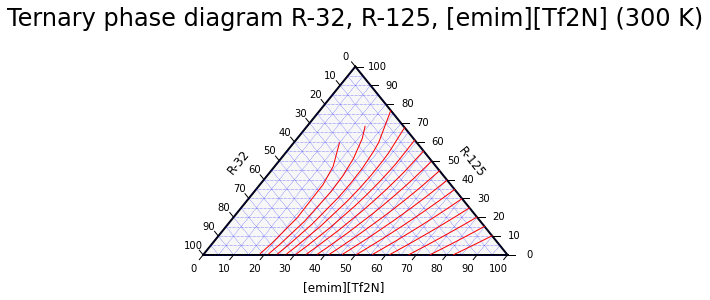

In [10]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [emim][Tf2N] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][Tf2N]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()
# tax.savefig('emimTf2N_ternary_300K_Psweep.pdf')